In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import random
from scipy.optimize import root
from collections import Counter
import sys
sys.path.append('lib/')
from degree_seq_bipartite import bipartite_degree_seq
from multiprocessing import Pool
import itertools

module loaded at  2020-05-15 14:48:58.377307


- degree of individual : number of cluster a person belongs to 
- degree of cluster:  number of people in the cluster

{'lam': 2}


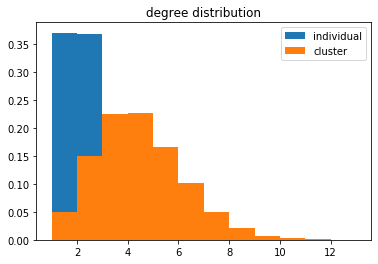

In [3]:
N_a = 100_000# n people
N_b = 50_000 #n clusters
a_mean = 2
b_mean = (a_mean )* N_a / N_b 
aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})

plt.hist(aseq,bins = np.arange(min(aseq),max(aseq)+1),density=True,label = 'individual')
plt.hist(bseq,bins = np.arange(min(bseq),max(bseq)+1),density=True,label = 'cluster')
plt.title('degree distribution')
plt.legend()

In [52]:
sum(aseq)/sum(bseq)

1.0

In [4]:
def simulate_percolation(N_a,N_b,a_mean,p):
    '''Parameters:
    p: float
         prob to remove a link, i.e not to trasmit disease
    '''
    aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
    BG = bipartite.generators.configuration_model(aseq,bseq)
    #print(np.mean(aseq),np.mean(bseq))
    edgs_list = list(BG.edges())
    edgs_to_rm = random.sample(edgs_list,k = int(len(edgs_list)*p))
    BG.remove_edges_from(edgs_to_rm)
    CC= max(nx.algorithms.connected_components(BG),key = len)
    CC = np.array(list(CC))
    return np.count_nonzero(CC<N_a)/N_a
def simulate_percolation_projected(N_a,N_b,a_mean,p):
    '''Parameters:
    p: float
         prob to remove a link, i.e not to trasmit disease
    '''
    aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
    BG = bipartite.generators.configuration_model(aseq,bseq)
    BG_1 = nx.Graph(BG)
    G = nx.algorithms.bipartite.projection.projected_graph(BG_1,range(N_a))
    #print(np.mean(aseq),np.mean(bseq))
    edgs_list = list(G.edges())
    edgs_to_rm = random.sample(edgs_list,k = int(len(edgs_list)*p))
    G.remove_edges_from(edgs_to_rm)
    CC= max(nx.algorithms.connected_components(G),key = len)
    CC = np.array(list(CC))
    return len(CC)/N_a

In [20]:
aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})

np.mean(aseq),np.mean(bseq)

{'lam': 1}


(1.0, 1.0)

In [140]:
BG = bipartite.generators.configuration_model(aseq,bseq)
p = 0.2# prob to remove a link, i.e not to trasmit disease
edgs_list = list(BG.edges())
edgs_to_rm = random.sample(edgs_list,k = int(len(edgs_list)*p))
BG.remove_edges_from(edgs_to_rm)
CC= max(nx.algorithms.connected_components(BG),key = len)


In [126]:
CC = np.array(list(CC))
print('fraction of individuals infected',np.count_nonzero(CC<N_a)/N_a,'\nfraction of clusters infected',np.count_nonzero(CC>=N_a)/N_b)



fraction of individuals infected 0.92267 
fraction of clusters infected 0.92363


In [19]:
simulate_percolation(N_a,N_b,a_mean,b_mean,p)

{'lam': 1}
2


1e-05

In [ ]:
a_means = np.linspace(1, 4,8)
p = 0.6
pool = Pool()
data = np.array(pool.starmap(simulate_percolation,itertools.product([N_a],[N_b],a_means,[p])))
pool.close()
pool = Pool()

data_proj =np.array(pool.starmap(simulate_percolation_projected,itertools.product([N_a],[N_b],a_means,[p])))
pool.close()

{'lam': 1.0}
{'lam': 1.8571428571428572}
{'lam': 1.4285714285714286}
{'lam': 2.2857142857142856}
{'lam': 2.7142857142857144}
{'lam': 3.142857142857143}
{'lam': 3.571428571428571}
{'lam': 4.0}


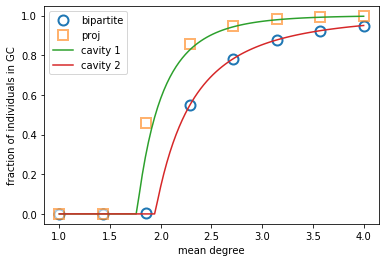

In [156]:
plt.plot(a_means,data,'o',mfc = 'w',mew = 2,ms = 10,label = 'bipartite')
plt.plot(a_means,data_proj,'s',label = 'proj',mfc = 'w',ms=10,mew = 2,alpha = 0.6)
a_means_thr = np.linspace(a_means.min(),a_means.max(),100)
plt.plot(a_means_thr,[model1(a_mean,a_mean*N_a/N_b,1-p).estimate() for a_mean in a_means_thr],label = 'cavity 1')
plt.plot(a_means_thr,[model2(a_mean,a_mean*N_a/N_b,1-p).estimate() for a_mean in a_means_thr],label = 'cavity 2')
plt.legend()
plt.xlabel('mean degree')
plt.ylabel('fraction of individuals in GC')
plt.savefig('percolation.pdf')

In [59]:
class theory_undirected:
    def __init__(self,a_mean,b_mean,T):
        self.a_mean = a_mean
        self.b_mean = b_mean
        self.T = T
        self.m
class model1:
    def __init__(self,a_mean,b_mean,T):
        self.a_mean = a_mean
        self.b_mean = b_mean
        self.T = T
        
    def cavity(self,x):
        c = self.a_mean-1
        d = self.b_mean-1
        T = self.T
        return    -x + (np.exp(-((d*T*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c)))*
          (-1 - d + (d*T*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c) + np.exp((d*T*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c)) + 
            d*np.exp((d*T*np.exp(-(c*x))*(-1 - c + c*x + np.exp(c*x) + c*np.exp(c*x)))/(1 + c))))/(1 + d)
    def estimate(self):
        f = self.cavity
        solution = root(f,1)
        return np.exp(-(self.a_mean-1)*solution.x)*(-1+np.exp((self.a_mean-1)*solution.x)+solution.x)
class model2:
    def __init__(self,a_mean,b_mean,T):
        self.a_mean = a_mean
        self.b_mean = b_mean
        self.T = T
        
    def cavity(self,x):
        c = self.a_mean-1
        d = self.b_mean-1
        T = self.T
        return           -x + (np.exp(-((d*T*np.exp(-(c*T*x))*(-1 - c + c*T*x + np.exp(c*T*x) + c*np.exp(c*T*x)))/(1 + c)))*
          (-1 - d + (d*T*np.exp(-(c*T*x))*(-1 - c + c*T*x + np.exp(c*T*x) + c*np.exp(c*T*x)))/(1 + c) + 
            np.exp((d*T*np.exp(-(c*T*x))*(-1 - c + c*T*x + np.exp(c*T*x) + c*np.exp(c*T*x)))/(1 + c)) + 
            d*np.exp((d*T*np.exp(-(c*T*x))*(-1 - c + c*T*x + np.exp(c*T*x) + c*np.exp(c*T*x)))/(1 + c))))/(1 + d)
    def estimate(self):
        f = self.cavity
        solution = root(f,1)
        return np.exp(-(self.a_mean-1)*solution.x*self.T)*(-1+np.exp((self.a_mean-1)*solution.x*self.T)+solution.x*self.T)


(-0.05, 0.049365840153954094)

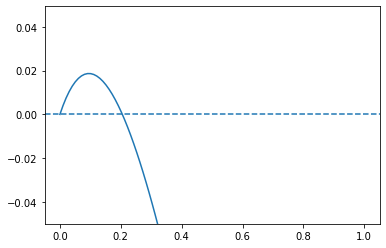

In [91]:
xs = np.linspace(0,1,100)
plt.plot(xs,[f(x,a_mean-1,b_mean-1,1-p) for x in xs])
plt.axhline(0,ls = '--')
plt.ylim(-0.05,)

In [97]:
solution = root(f,1,args=(a_mean-1,b_mean-1,1-p))
print(solution)
np.exp(-(a_mean-1)*solution.x)*(-1+np.exp((a_mean-1)*solution.x)+solution.x)

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.13182854e-12])
       r: array([0.73279659])
  status: 1
 success: True
       x: array([0.59214458])


array([0.87521109])

In [ ]:
solution.x

<BarContainer object of 17 artists>

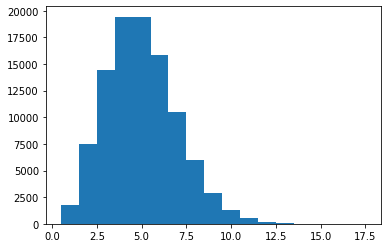

In [83]:
count = Counter(aseq)
plt.bar(count.keys(),count.values(),1)

In [74]:
Counter(aseq).values()

dict_values([19440, 19428, 7510, 1796, 15831, 2897, 10514, 567, 14479, 188, 5993, 1269, 58, 24, 4, 1, 1])

In [37]:
BG_1 = nx.Graph(BG)

<BarContainer object of 17 artists>

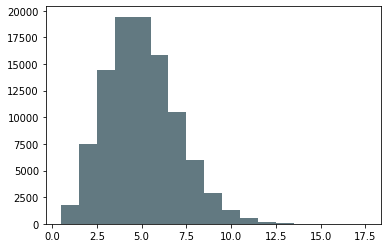

In [107]:
plt.bar(*zip(*Counter(dict(BG_1.degree(range(N_a))).values()).items()),1)
plt.bar(*zip(*Counter(aseq).items()),1,alpha = 0.3)

In [122]:
BG_1 = nx.Graph(BG)
G = nx.algorithms.bipartite.projection.projected_graph(BG_1,range(N_a))

In [124]:
edgs_list = list(G.edges())
edgs_to_rm = random.sample(edgs_list,k = int(len(edgs_list)*p))
G.remove_edges_from(edgs_to_rm)
CC= max(nx.algorithms.connected_components(G),key = len)
CC = np.array(list(CC))
print('fraction of individuals infected',np.count_nonzero(CC<N_a)/N_a,'\nfraction of clusters infected',np.count_nonzero(CC>=N_a)/N_b)


fraction of individuals infected 0.90029 
fraction of clusters infected 0.0


In [142]:
print(simulate_percolation(N_a,N_b,a_mean,p),simulate_percolation_projected(N_a,N_b,a_mean,p))

{'lam': 3}
{'lam': 3}
0.92158 0.98219


In [123]:
len(G.edges()) ,len(BG_1.edges())

(256272, 239928)

In [114]:
nx.algorithms.bipartite.projection.projected_graph?

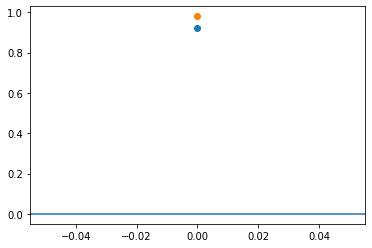

In [145]:
plt.plot(0.92,'o')
plt.plot(0.98,'o')
plt.axhline(0)